## TELECOM OPERATOR

The telecom operator would like to forecast their churn of clients.

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

The data consists of 4 files: 

* Contract

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Dataset "contract" - client's contract information, has 7043 entries with 8 columns ( 7 -string type, 1 - float).

We can see that column "TotalCharges" need to be converted to numeric type.

In [5]:
contract['TotalCharges']=pd.to_numeric(contract['TotalCharges'],errors='coerce')

Let's convert column "BeginDate" to date type.

In [6]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

* Client

In [7]:
client = pd.read_csv('/datasets/final_provider/personal.csv')

In [8]:
client.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Dataset "client" - the client's personal data, has 7043 entries with 5 columns ( 4 -string type, 1 - interger).

* Internet

In [10]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Dataset "internet" - information about Internet services, has 5517 entries with 8 columns of string type.

* Phone

In [13]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [14]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Dataset "phone" -  information about telephone services, has 6361 entries with 2 columns of string type.

Now, we"ll merge all datasets. First, we'll load all the files as data frame into a list. Then merge the files using reduce function.

In [16]:
data_frames = [contract, client, internet, phone]

data_merged = reduce(lambda  left,right: pd.merge(left,right,on=['customerID'],
                                                  how='outer'), data_frames)

In [17]:
data_merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [18]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(16)
memo

Let's check if we have missing values.

In [19]:
data_merged.isnull().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

We have missing values in such columns : InternetService, OnlineSecurity, OnlineBackup,  DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines. 
We can assume here that customer doesn't have such services. So, we will fill mising values with 'No service'.

In [20]:
data_merged[['InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines']] = data_merged[['InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','MultipleLines']].fillna('No service')

There are 11 missing values in TotalCharges column. We"ll drop them (this is really small number of NaNs) 

In [21]:
data_merged.dropna(inplace = True)

Let's check our data for duplicates.

In [22]:
data_merged[data_merged.duplicated(keep=False)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


There are no duplicates in the dataset.

Now let's find out how long clients stay with us. In order to do this, we"ll fill "No" values in the column "EndDate" with date 2020-02-01 (The contract information is valid as of February 1, 2020.)

In [23]:
data_merged['End_Date'] = data_merged['EndDate'].replace({"No":"2020-02-01"})

Convert it into date type

In [24]:
 data_merged['End_Date'] = pd.to_datetime(data_merged['End_Date'], format='%Y-%m-%d')

Now we'll find the difference beetwen BeginDate and End_Date in term of month.

In [25]:
data_merged['Tenure']= ((data_merged['End_Date'] - data_merged['BeginDate'])/np.timedelta64(1, 'M')).astype(int)

Let's add column "Churn", it will be our target value. We"ll replace "No" with 0, all the rest with 1. So, 0 - client stays with us, 1 - client exited.

In [26]:
data_merged['Churn'] = [0 if x == "No" else 1 for x in data_merged['EndDate']]

In [27]:
data_merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,End_Date,Tenure,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,No service,2020-02-01,1,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,No,2020-02-01,34,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,No,2019-12-01,2,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,No service,2020-02-01,45,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,No,2019-11-01,2,1


In [28]:
df = data_merged.copy()

Let's look at our dataset.

In [29]:
data_merged.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'End_Date', 'Tenure',
       'Churn'],
      dtype='object')

Let's plot bar charts.

In [30]:
col = ['Churn', 'Type', 'PaperlessBilling', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'InternetService','OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'PaymentMethod']

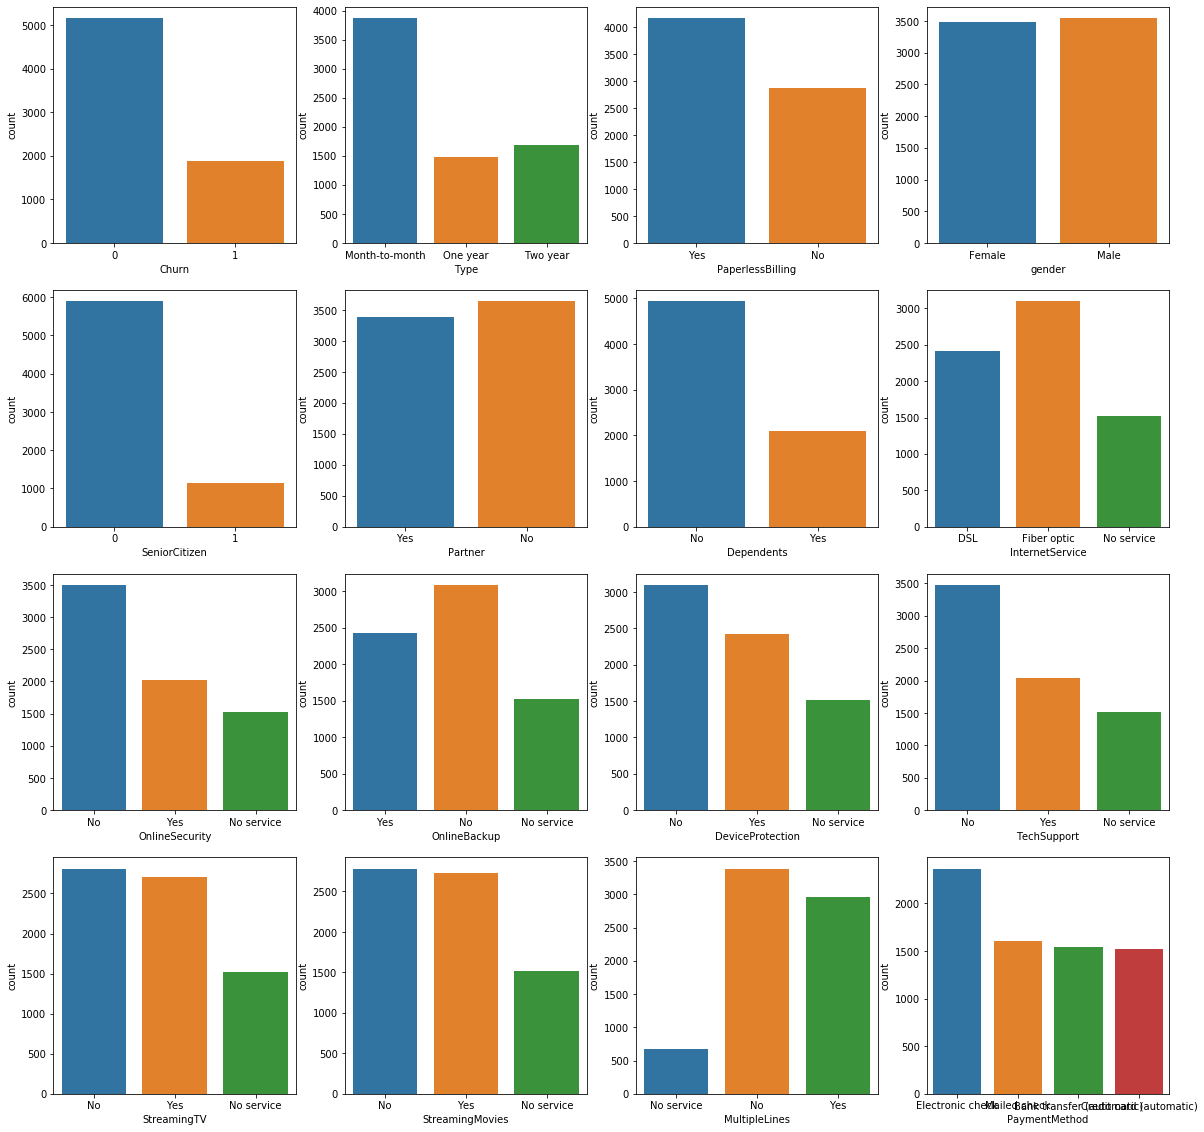

In [31]:
fig , ax = plt.subplots(4,4,figsize=(20,20))

for axis,column in zip(ax.flat,col):
    sns.countplot(x=data_merged[column],ax=axis)   

Here are some conclusions from the graphs:

In [32]:
class_frequency = data_merged['Churn'].value_counts(normalize=True)
class_frequency

0    0.734215
1    0.265785
Name: Churn, dtype: float64

We can see from graphs and above that we have imbalanced dataset: class '0' : 73% and class '1' : 27%. 

* Most clients have month-to-month contract
* Equal number of men and women
* More clients have a paperless billing
* 6 times less senior citizens
* Equal distribution of individuals with partners and without
* About twice more individuals without dependents
* Most clients have internet through a fiber optic cable
* Most clients have electronic check

Now, let's look at the distribution of Tenure, Monthly and Total Charges.

In [33]:
col1=['Tenure', 'MonthlyCharges', 'TotalCharges']

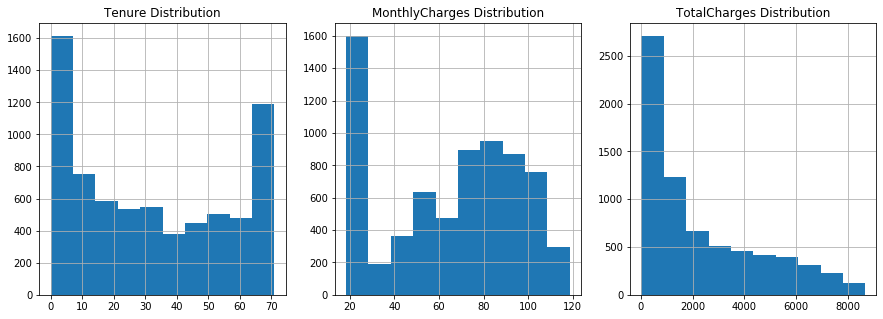

In [34]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(figsize=(15,5),ax=ax)
        ax.set_title(var_name+" Distribution")
    plt.show()


draw_histograms(data_merged, col1, 1, 3)

We have two peaks in Tenure Distribution (in month) that shows us that many clients stay with us for short period of time (less than a year) and many clients stay for a long period (more than 5 years).

We can see also that many clients have small charges (people usually choose the cheapest offer).

Now, let's look at the features together with Churn.

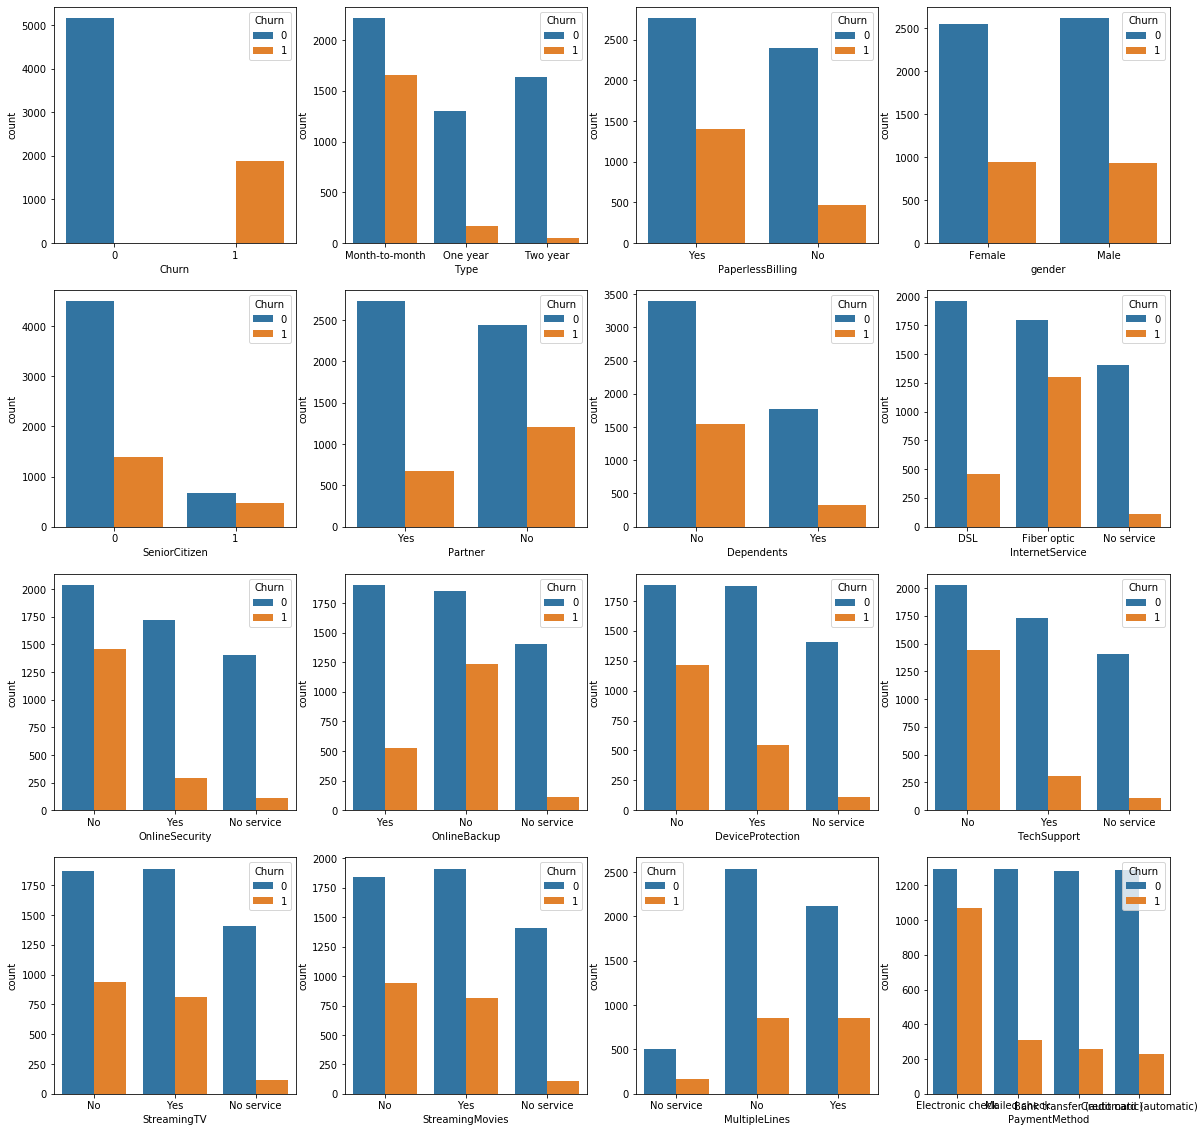

In [35]:
fig , ax = plt.subplots(4,4,figsize=(20,20))

for axis,column in zip(ax.flat,col):
    sns.countplot(x=data_merged[column],hue = data_merged['Churn'], ax=axis)   

Some conclusions from the graphs:

* Those who have a month-to-month contract, fiber optic are more likely to churn 
* Those who don't have such services like Online Scerurity, Online Backup, Device Protection, Tech Support are more likely to leave the company 

Now let's look at Tenure, Monthly and Total Charges regarding Churn.

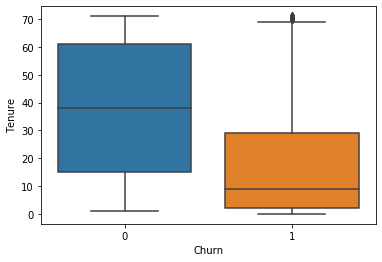

In [36]:
sns.boxplot(x = data_merged['Churn'], y = data_merged['Tenure']);

On average those who left the company stayed less than a year (10 months). 
The clients who do not churn, they tend to stay for a longer tenure (about 3 years)

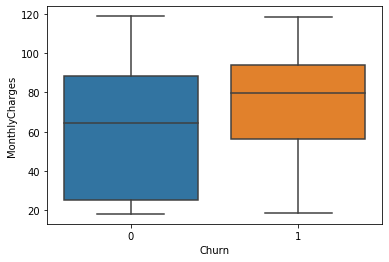

In [37]:
sns.boxplot(x = data_merged['Churn'], y = data_merged['MonthlyCharges']);

On average, clients who churn have higher monthly charges.

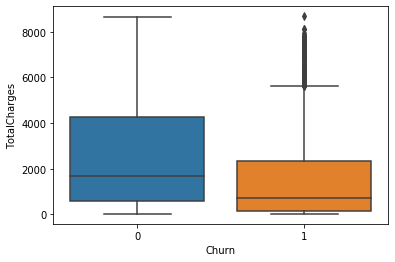

In [38]:
sns.boxplot(x = data_merged['Churn'], y = data_merged['TotalCharges']);

On average, total charges for those who churn are lower, because they stay for a short time.

#### Now let's prepare our data for ML models. 

Categorical features with two options (Yes, No) and three options (Yes, No + No service -- the same meaning) we"ll convert them into binary values Yes - 1, No - 0 (also, No and No service -- 0).

In [39]:
data_merged.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'End_Date', 'Tenure',
       'Churn'],
      dtype='object')

In [40]:
col2 = ['PaperlessBilling','Partner', 'Dependents','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'] 

for column in col2:
    data_merged[column] = [1 if x == "Yes" else 1 for x in data_merged[column]]
    
# for column "gender"
data_merged['gender'] = data_merged['gender'].replace({'Male':1, 'Female':0})


For categorical features with more than two options (InternetService, Contract, PaymentMethod) we"ll use pd.get_dummies() in order to convert them in numbers

In [41]:
data_merged = pd.get_dummies(data_merged, columns=['Type', 'InternetService', 'PaymentMethod'], drop_first = True)

Numeric features (Tenure, MonthlyCharges, TotalCharges) we"ll scale them using StandardScaler().

In [42]:
numeric = ['Tenure','MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
scaler.fit(data_merged[numeric])
data_merged[numeric] = scaler.transform(data_merged[numeric])

Let's drop useless columns such as: customerId, BeginDate, EndDate, End_date

In [43]:
data_merged = data_merged.drop(['customerID','BeginDate', 'EndDate', 'End_Date'], axis = 1)

In [44]:
data_merged.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,MultipleLines,Tenure,Churn,Type_One year,Type_Two year,InternetService_Fiber optic,InternetService_No service,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,-1.161694,-0.994194,0,0,1,1,1,1,1,...,1,-1.273431,0,0,0,0,0,0,1,0
1,1,-0.260878,-0.173740,1,0,1,1,1,1,1,...,1,0.072727,0,1,0,0,0,0,0,1
2,1,-0.363923,-0.959649,1,0,1,1,1,1,1,...,1,-1.232638,1,0,0,0,0,0,0,1
3,1,-0.747850,-0.195248,1,0,1,1,1,1,1,...,1,0.521446,0,1,0,0,0,0,0,0
4,1,0.196178,-0.940457,0,0,1,1,1,1,1,...,1,-1.232638,1,0,0,1,0,0,1,0


Splitting the data into training (80%) and testing sets (20%)

In [45]:
X = data_merged.drop('Churn', axis=1)
Y = data_merged['Churn']

In [46]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

#### ML models.

Since our target variable is binary, we are dealing with binary classification task. Let's try different models and compare them in terms of ROC_AUC.

* Logistic Regression

In [47]:
model_LR = LogisticRegression(random_state=12345, solver='liblinear')
model_LR.fit(x_train, y_train)

y_LR_prob = model_LR.predict_proba(x_test)[:,1]
y_LR_pred = model_LR.predict(x_test)

LR_score = roc_auc_score(y_test,y_LR_prob)
print('AUC-ROC Logistic Regression: {}'.format(LR_score))

AUC-ROC Logistic Regression: 0.829899415543741


Let's look at confusion matrix and some metrics.

In [48]:
def conf_matrix(y_test, pred):
    cm = confusion_matrix(y_test, pred)
    fig = plt.plot(figsize=(8,5))
    sns.heatmap(cm,annot=True,cmap='Purples',fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return plt.show()

In [49]:
def get_metrics(model, X_train, y_train, X_test, y_test):
    train_preds, train_probs = model.predict(X_train), model.predict_proba(X_train)[:, 1]
    test_preds, test_probs = model.predict(X_test), model.predict_proba(X_test)[:, 1]
    
    train_scores = [accuracy_score(y_train, train_preds), roc_auc_score(y_train, train_probs),
                    precision_score(y_train, train_preds), recall_score(y_train, train_preds),
                    f1_score(y_train, train_preds)]
    
    test_scores = [accuracy_score(y_test, test_preds), roc_auc_score(y_test, test_probs),
                    precision_score(y_test, test_preds), recall_score(y_test, test_preds),
                    f1_score(y_test, test_preds)]
    
    
    scores = pd.DataFrame({
        'train': train_scores,
        'test': test_scores
    }, index=['accuracy', 'roc_auc', 'precision', 'recall', 'f1_score'])
    
    return scores


In [50]:
LR_metrics = get_metrics(model_LR, x_train, y_train, x_test, y_test)
LR_metrics

,train,test
accuracy,0.804267,0.790334
roc_auc,0.845991,0.829899
precision,0.657097,0.629508
recall,0.551171,0.513369
f1_score,0.599491,0.565538


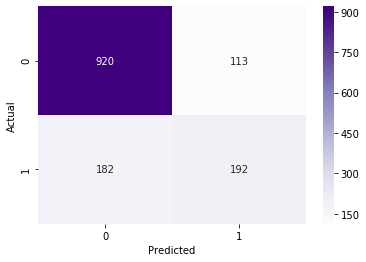

In [51]:
conf_matrix(y_test, y_LR_pred)

* #### Random Forest Classifier

Let's tune hyperparameters for Random Forest using RandomizedSearch.

In [52]:
model_RF = RandomForestClassifier()

parameters = {'max_depth'     : [6, 7, 10],
              'n_estimators'  : [40, 100, 500]}
    
randm = RandomizedSearchCV(estimator=model_RF, param_distributions = parameters, 
                           scoring='roc_auc', cv = 3, n_iter = 10, 
                           n_jobs=-1, verbose = 2, random_state=12345)

randm_results = randm.fit(x_train, y_train)


print("\n The best score: ", randm_results.best_score_)

print("\n The best parameters: ", randm_results.best_params_)

# Predict after fitting RandomizedSearchCV with best parameters
y_RF_prob = randm.predict_proba(x_test)[:,1]
y_RF_pred = randm.predict(x_test)
 
RF_score = roc_auc_score(y_test,y_RF_prob)

print("\n ROC-AUC Random Forest: ", RF_score)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] n_estimators=40, max_depth=6 ....................................
[CV] ..................... n_estimators=40, max_depth=6, total=   0.2s
[CV] n_estimators=40, max_depth=6 ....................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ..................... n_estimators=40, max_depth=6, total=   0.2s
[CV] n_estimators=40, max_depth=6 ....................................
[CV] ..................... n_estimators=40, max_depth=6, total=   0.1s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .................... n_estimators=100, max_depth=6, total=   0.4s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .................... n_estimators=100, max_depth=6, total=   0.3s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .................... n_estimators=100, max_depth=6, total=   0.4s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .................... n_estimators=500, max_depth=6, total=   1.9s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .................... n_estimators=500, max_depth=6, total=   1.7s
[CV] n_estimators=500, max_depth=6 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   22.5s finished



 The best score:  0.8552518199063016

 The best parameters:  {'n_estimators': 500, 'max_depth': 7}

 ROC-AUC Random Forest:  0.837422542721216


We got better score with Random Forest than with Logistic Regression.

In [53]:
RF_metrics = get_metrics(randm, x_train, y_train, x_test, y_test)
RF_metrics

,train,test
accuracy,0.827556,0.800284
roc_auc,0.889205,0.837423
precision,0.736274,0.679537
recall,0.547157,0.470588
f1_score,0.627782,0.556082


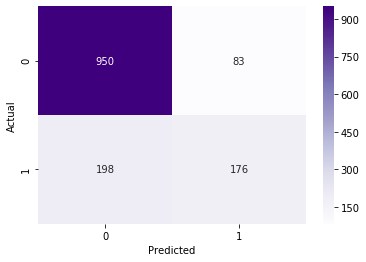

In [54]:
conf_matrix(y_test, y_RF_pred)

* #### XGBoost

In [55]:
model_XGB = XGBClassifier() 

XGB_params = {'depth'        : [6,10],
              'learning_rate' : [0.03, 0.1],
              'n_estimators'  : [60,100] }

random_search = RandomizedSearchCV(model_XGB, XGB_params, n_iter=10, n_jobs=-1, cv=5, 
                                   scoring= 'roc_auc', verbose = 2, random_state=12345)

random_search.fit(x_train, y_train)

print("\n The best parameters: ", random_search.best_params_)

# Predict after fitting RandomizedSearchCV with best parameters
y_XGB_prob = random_search.predict_proba(x_test)[:,1]
y_XGB_pred = random_search.predict(x_test)
 
XGB_score = roc_auc_score(y_test,y_XGB_prob)

print("\n ROC-AUC LGBM: ", XGB_score)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................
[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................
[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................
[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   0.5s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   0.5s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   0.4s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.8s finished



 The best parameters:  {'n_estimators': 100, 'learning_rate': 0.1, 'depth': 6}

 ROC-AUC LGBM:  0.8421359831444678


In [56]:
XGB_metrics = get_metrics(random_search, x_train, y_train, x_test, y_test)
XGB_metrics

,train,test
accuracy,0.828444,0.798152
roc_auc,0.878908,0.842136
precision,0.734929,0.669173
recall,0.554515,0.475936
f1_score,0.632101,0.556250


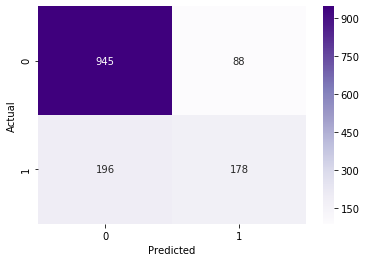

In [57]:
conf_matrix(y_test, y_XGB_pred)

* #### CatBoost

For LightGBM and CatBoost we'll convert all 'object' data types to 'categorical' data types

In [58]:
# drop usless columns
df = df.drop(['customerID','BeginDate', 'EndDate', 'End_Date'], axis = 1)

In [59]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Tenure,Churn
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No service,1,0
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,34,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,2,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No service,45,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,2,1


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
MultipleLines       7032 non-null object
Tenure              7032 non-null int64
Churn               7032 non-null int64
dtypes: float64(2), int64(3), object(14)
memory usage: 1.1+ MB


In [61]:
df.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Tenure', 'Churn'],
      dtype='object')

In [62]:
target = df['Churn']
features = df.drop('Churn', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [63]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for header in cat_features:
    X_train[header] = X_train[header].astype('category')
    X_test[header] = X_test[header].astype('category')

In [64]:
model_CB = CatBoostClassifier()

parameters = {'depth'         : [6,10],
              'learning_rate' : [0.03, 0.1],
              'n_estimators'  : [60, 100] }
    
randm = RandomizedSearchCV(estimator=model_CB, param_distributions = parameters, scoring='roc_auc',  
                               cv = 2, n_iter = 10, n_jobs=-1, verbose = 2, random_state=12345)

randm_results=randm.fit(X_train, Y_train,cat_features=cat_features)


print("\n The best score: ", randm_results.best_score_)

print("\n The best parameters: ", randm_results.best_params_)

# Predict after fitting RandomizedSearchCV with best parameters
y_CB_prob = randm.predict_proba(X_test)[:,1]
y_CB_pred = randm.predict(X_test)
 
CB_score = roc_auc_score(Y_test,y_CB_prob)

print("\n ROC-AUC CatBoost: ", CB_score)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6821233	total: 53.6ms	remaining: 3.16s
1:	learn: 0.6717353	total: 56.8ms	remaining: 1.65s
2:	learn: 0.6611790	total: 59.4ms	remaining: 1.13s
3:	learn: 0.6512911	total: 62ms	remaining: 868ms
4:	learn: 0.6424450	total: 149ms	remaining: 1.63s
5:	learn: 0.6335426	total: 151ms	remaining: 1.36s
6:	learn: 0.6245745	total: 155ms	remaining: 1.17s
7:	learn: 0.6168034	total: 158ms	remaining: 1.02s
8:	learn: 0.6090908	total: 248ms	remaining: 1.4s
9:	learn: 0.6018233	total: 251ms	remaining: 1.25s
10:	learn: 0.5948140	total: 254ms	remaining: 1.13s
11:	learn: 0.5876154	total: 265ms	remaining: 1.06s
12:	learn: 0.5812148	total: 350ms	remaining: 1.26s
13:	learn: 0.5752156	total: 354ms	remaining: 1.16s
14:	learn: 0.5689250	total: 444ms	remaining: 1.33s
15:	learn: 0.5633937	total: 447ms	remaining: 1.23s
16:	learn: 0.5579536	total: 450ms	remaining: 1.14s
17:	learn: 0.5526497	total: 459ms	remaining: 1.07s
18:	learn: 0.5472080	total: 543ms	remaining: 1.17s
19:	learn: 0.5419942	total: 546ms	remain

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


0:	learn: 0.6827985	total: 4.46ms	remaining: 263ms
1:	learn: 0.6730056	total: 10.7ms	remaining: 310ms
2:	learn: 0.6630411	total: 54.9ms	remaining: 1.04s
3:	learn: 0.6532719	total: 60.3ms	remaining: 844ms
4:	learn: 0.6438068	total: 63.7ms	remaining: 701ms
5:	learn: 0.6353309	total: 154ms	remaining: 1.38s
6:	learn: 0.6271896	total: 159ms	remaining: 1.2s
7:	learn: 0.6195272	total: 164ms	remaining: 1.07s
8:	learn: 0.6119408	total: 251ms	remaining: 1.42s
9:	learn: 0.6044772	total: 256ms	remaining: 1.28s
10:	learn: 0.5977959	total: 272ms	remaining: 1.21s
11:	learn: 0.5909397	total: 352ms	remaining: 1.41s
12:	learn: 0.5841932	total: 356ms	remaining: 1.29s
13:	learn: 0.5779763	total: 362ms	remaining: 1.19s
14:	learn: 0.5721940	total: 453ms	remaining: 1.36s
15:	learn: 0.5669078	total: 458ms	remaining: 1.26s
16:	learn: 0.5614068	total: 462ms	remaining: 1.17s
17:	learn: 0.5561013	total: 551ms	remaining: 1.29s
18:	learn: 0.5512891	total: 557ms	remaining: 1.2s
19:	learn: 0.5468755	total: 561ms	rema

[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   5.0s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
0:	learn: 0.6827985	total: 3.3ms	remaining: 326ms
1:	learn: 0.6730056	total: 6.4ms	remaining: 313ms
2:	learn: 0.6630411	total: 9.31ms	remaining: 301ms
3:	learn: 0.6532719	total: 68.4ms	remaining: 1.64s
4:	learn: 0.6438068	total: 71.8ms	remaining: 1.36s
5:	learn: 0.6353309	total: 74.7ms	remaining: 1.17s
6:	learn: 0.6271896	total: 77.4ms	remaining: 1.03s
7:	learn: 0.6195272	total: 166ms	remaining: 1.91s
8:	learn: 0.6119408	total: 169ms	remaining: 1.71s
9:	learn: 0.6044772	total: 172ms	remaining: 1.55s
10:	learn: 0.5977959	total: 175ms	remaining: 1.41s
11:	learn: 0.5909397	total: 266ms	remaining: 1.95s
12:	learn: 0.5841932	total: 270ms	remaining: 1.8s
13:	learn: 0.5779763	total: 272ms	remaining: 1.67s
14:	learn: 0.5721940	total: 363ms	remaining: 2.06s
15:	learn: 0.5669078	total: 366ms	remaining: 1.92s
16:	learn: 0.5614068	total: 369ms	remaining: 1.8

58:	learn: 0.3773744	total: 1.34s	remaining: 22.7ms
59:	learn: 0.3765205	total: 1.34s	remaining: 0us
[CV] ...... n_estimators=60, learning_rate=0.1, depth=6, total=   2.5s
[CV] n_estimators=60, learning_rate=0.1, depth=6 .....................
0:	learn: 0.6597562	total: 3.15ms	remaining: 186ms
1:	learn: 0.6315492	total: 6.14ms	remaining: 178ms
2:	learn: 0.6052995	total: 9.18ms	remaining: 174ms
3:	learn: 0.5824142	total: 61.7ms	remaining: 863ms
4:	learn: 0.5623816	total: 64.6ms	remaining: 710ms
5:	learn: 0.5471768	total: 67.3ms	remaining: 605ms
6:	learn: 0.5330676	total: 69.9ms	remaining: 529ms
7:	learn: 0.5186922	total: 161ms	remaining: 1.05s
8:	learn: 0.5081296	total: 163ms	remaining: 922ms
9:	learn: 0.4984126	total: 165ms	remaining: 827ms
10:	learn: 0.4889753	total: 168ms	remaining: 748ms
11:	learn: 0.4806584	total: 261ms	remaining: 1.04s
12:	learn: 0.4729994	total: 264ms	remaining: 953ms
13:	learn: 0.4675611	total: 265ms	remaining: 872ms
14:	learn: 0.4623461	total: 269ms	remaining: 8

94:	learn: 0.3654557	total: 2.2s	remaining: 116ms
95:	learn: 0.3652282	total: 2.2s	remaining: 91.7ms
96:	learn: 0.3645786	total: 2.29s	remaining: 70.8ms
97:	learn: 0.3644891	total: 2.29s	remaining: 46.8ms
98:	learn: 0.3643435	total: 2.29s	remaining: 23.2ms
99:	learn: 0.3642349	total: 2.29s	remaining: 0us
[CV] ..... n_estimators=100, learning_rate=0.1, depth=6, total=   3.8s
[CV] n_estimators=100, learning_rate=0.1, depth=6 ....................
0:	learn: 0.6597562	total: 3.27ms	remaining: 324ms
1:	learn: 0.6315492	total: 6.3ms	remaining: 309ms
2:	learn: 0.6052995	total: 9.36ms	remaining: 303ms
3:	learn: 0.5824142	total: 96.6ms	remaining: 2.32s
4:	learn: 0.5623816	total: 99.7ms	remaining: 1.89s
5:	learn: 0.5471768	total: 103ms	remaining: 1.61s
6:	learn: 0.5330676	total: 105ms	remaining: 1.4s
7:	learn: 0.5186922	total: 195ms	remaining: 2.24s
8:	learn: 0.5081296	total: 197ms	remaining: 1.99s
9:	learn: 0.4984126	total: 199ms	remaining: 1.79s
10:	learn: 0.4889753	total: 205ms	remaining: 1.66

53:	learn: 0.4441791	total: 2.65s	remaining: 295ms
54:	learn: 0.4423423	total: 2.66s	remaining: 242ms
55:	learn: 0.4404518	total: 2.75s	remaining: 197ms
56:	learn: 0.4388616	total: 2.76s	remaining: 145ms
57:	learn: 0.4374298	total: 2.85s	remaining: 98.4ms
58:	learn: 0.4358454	total: 2.86s	remaining: 48.4ms
59:	learn: 0.4342365	total: 2.95s	remaining: 0us
[CV] .... n_estimators=60, learning_rate=0.03, depth=10, total=   4.3s
[CV] n_estimators=60, learning_rate=0.03, depth=10 ...................
0:	learn: 0.6836940	total: 9.04ms	remaining: 533ms
1:	learn: 0.6738232	total: 58.4ms	remaining: 1.69s
2:	learn: 0.6638864	total: 68.5ms	remaining: 1.3s
3:	learn: 0.6549023	total: 158ms	remaining: 2.21s
4:	learn: 0.6472417	total: 166ms	remaining: 1.83s
5:	learn: 0.6384902	total: 261ms	remaining: 2.35s
6:	learn: 0.6307451	total: 355ms	remaining: 2.69s
7:	learn: 0.6232267	total: 364ms	remaining: 2.37s
8:	learn: 0.6153167	total: 367ms	remaining: 2.08s
9:	learn: 0.6075623	total: 457ms	remaining: 2.29s

90:	learn: 0.3986964	total: 4.32s	remaining: 427ms
91:	learn: 0.3978959	total: 4.41s	remaining: 383ms
92:	learn: 0.3972576	total: 4.5s	remaining: 339ms
93:	learn: 0.3964497	total: 4.51s	remaining: 288ms
94:	learn: 0.3957827	total: 4.51s	remaining: 238ms
95:	learn: 0.3949783	total: 4.61s	remaining: 192ms
96:	learn: 0.3943328	total: 4.7s	remaining: 145ms
97:	learn: 0.3934985	total: 4.71s	remaining: 96.1ms
98:	learn: 0.3927162	total: 4.8s	remaining: 48.5ms
99:	learn: 0.3923578	total: 4.8s	remaining: 0us
[CV] ... n_estimators=100, learning_rate=0.03, depth=10, total=   6.0s
[CV] n_estimators=100, learning_rate=0.03, depth=10 ..................
0:	learn: 0.6836940	total: 9.36ms	remaining: 926ms
1:	learn: 0.6738232	total: 14.5ms	remaining: 712ms
2:	learn: 0.6638864	total: 23ms	remaining: 743ms
3:	learn: 0.6549023	total: 26.5ms	remaining: 637ms
4:	learn: 0.6472417	total: 121ms	remaining: 2.29s
5:	learn: 0.6384902	total: 214ms	remaining: 3.35s
6:	learn: 0.6307451	total: 223ms	remaining: 2.96s


49:	learn: 0.3514156	total: 2.72s	remaining: 545ms
50:	learn: 0.3499446	total: 2.73s	remaining: 482ms
51:	learn: 0.3486589	total: 2.82s	remaining: 434ms
52:	learn: 0.3471926	total: 2.91s	remaining: 385ms
53:	learn: 0.3463768	total: 2.92s	remaining: 325ms
54:	learn: 0.3459227	total: 2.92s	remaining: 266ms
55:	learn: 0.3443999	total: 3.02s	remaining: 215ms
56:	learn: 0.3431133	total: 3.11s	remaining: 164ms
57:	learn: 0.3421476	total: 3.12s	remaining: 108ms
58:	learn: 0.3409573	total: 3.21s	remaining: 54.4ms
59:	learn: 0.3409102	total: 3.22s	remaining: 0us
[CV] ..... n_estimators=60, learning_rate=0.1, depth=10, total=   4.4s
[CV] n_estimators=60, learning_rate=0.1, depth=10 ....................
0:	learn: 0.6625020	total: 9.91ms	remaining: 585ms
1:	learn: 0.6316257	total: 101ms	remaining: 2.93s
2:	learn: 0.6058044	total: 111ms	remaining: 2.11s
3:	learn: 0.5838418	total: 201ms	remaining: 2.81s
4:	learn: 0.5676394	total: 210ms	remaining: 2.31s
5:	learn: 0.5502257	total: 304ms	remaining: 2.7

87:	learn: 0.3192313	total: 4.94s	remaining: 674ms
88:	learn: 0.3187628	total: 4.95s	remaining: 612ms
89:	learn: 0.3182248	total: 5.05s	remaining: 561ms
90:	learn: 0.3180388	total: 5.14s	remaining: 508ms
91:	learn: 0.3176081	total: 5.15s	remaining: 448ms
92:	learn: 0.3173001	total: 5.24s	remaining: 395ms
93:	learn: 0.3160924	total: 5.34s	remaining: 341ms
94:	learn: 0.3152706	total: 5.34s	remaining: 281ms
95:	learn: 0.3147101	total: 5.44s	remaining: 227ms
96:	learn: 0.3145398	total: 5.45s	remaining: 168ms
97:	learn: 0.3143631	total: 5.54s	remaining: 113ms
98:	learn: 0.3135775	total: 5.55s	remaining: 56ms
99:	learn: 0.3133590	total: 5.64s	remaining: 0us
[CV] .... n_estimators=100, learning_rate=0.1, depth=10, total=   6.9s
[CV] n_estimators=100, learning_rate=0.1, depth=10 ...................
0:	learn: 0.6625020	total: 9.46ms	remaining: 936ms
1:	learn: 0.6316257	total: 14.4ms	remaining: 708ms
2:	learn: 0.6058044	total: 77.8ms	remaining: 2.52s
3:	learn: 0.5838418	total: 81.4ms	remaining: 

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.2min finished


0:	learn: 0.6534838	total: 4.77ms	remaining: 472ms
1:	learn: 0.6214218	total: 14ms	remaining: 688ms
2:	learn: 0.5949274	total: 22.2ms	remaining: 717ms
3:	learn: 0.5733603	total: 25.8ms	remaining: 619ms
4:	learn: 0.5544025	total: 29.3ms	remaining: 557ms
5:	learn: 0.5371589	total: 119ms	remaining: 1.86s
6:	learn: 0.5229342	total: 123ms	remaining: 1.63s
7:	learn: 0.5090895	total: 128ms	remaining: 1.47s
8:	learn: 0.4981827	total: 217ms	remaining: 2.19s
9:	learn: 0.4877513	total: 221ms	remaining: 1.99s
10:	learn: 0.4780005	total: 225ms	remaining: 1.82s
11:	learn: 0.4703282	total: 315ms	remaining: 2.31s
12:	learn: 0.4633062	total: 318ms	remaining: 2.13s
13:	learn: 0.4564854	total: 322ms	remaining: 1.98s
14:	learn: 0.4515813	total: 330ms	remaining: 1.87s
15:	learn: 0.4466185	total: 414ms	remaining: 2.17s
16:	learn: 0.4433802	total: 418ms	remaining: 2.04s
17:	learn: 0.4388618	total: 423ms	remaining: 1.93s
18:	learn: 0.4343735	total: 514ms	remaining: 2.19s
19:	learn: 0.4301901	total: 517ms	rema

In [65]:
CB_metrics = get_metrics(randm, X_train, Y_train, X_test, Y_test)
CB_metrics

,train,test
accuracy,0.823467,0.821606
roc_auc,0.870287,0.863322
precision,0.705588,0.727586
recall,0.569314,0.550914
f1_score,0.630168,0.627043


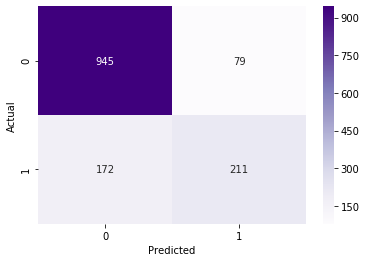

In [66]:
conf_matrix(Y_test, y_CB_pred)

* #### LGBM

In [67]:
lgbm_model = lgb.LGBMClassifier()
                          
lgbm_params = {'depth'        : [6,10],
              'learning_rate' : [0.03, 0.1],
              'n_estimators'  : [60,100] }

random_search = RandomizedSearchCV(lgbm_model, lgbm_params, n_iter=10, n_jobs=-1, cv=5, 
                                   scoring= 'roc_auc', verbose = 2, random_state=12345)

random_search.fit(X_train, Y_train, categorical_feature= cat_features)

print("\n The best parameters: ", random_search.best_params_)

# Predict after fitting RandomizedSearchCV with best parameters
y_LGBM_prob = random_search.predict_proba(X_test)[:,1]
y_LGBM_pred = random_search.predict(X_test)
 
LGBM_score = roc_auc_score(Y_test,y_LGBM_prob)

print("\n ROC-AUC LGBM: ", LGBM_score)



Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.2s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.2s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................
[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.2s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................
[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.2s
[CV] n_estimators=60, learning_rate=0.03, depth=6 ....................
[CV] ..... n_estimators=60, learning_rate=0.03, depth=6, total=   0.2s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .... n_estimators=100, learning_rate=0.03, depth=6, total=   0.3s
[CV] n_estimators=100, learning_rate=0.03, depth=6 ...................
[CV] .

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.6s finished



 The best parameters:  {'n_estimators': 100, 'learning_rate': 0.03, 'depth': 6}

 ROC-AUC LGBM:  0.8594145214588773


In [68]:
LGBM_metrics = get_metrics(random_search, X_train, Y_train, X_test, Y_test)
LGBM_metrics

,train,test
accuracy,0.843911,0.816631
roc_auc,0.907969,0.859415
precision,0.783582,0.751004
recall,0.565276,0.488251
f1_score,0.656763,0.591772


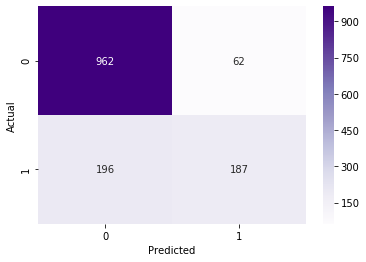

In [69]:
conf_matrix(Y_test, y_LGBM_pred)

Looking at confusion metrics of the models above, we can see that CatBoost has the smalest number of False Negatives. False Negatives mean that client will churn, but the model says he will not and we loose money.

Let's look at the results of all models.

In [70]:
results = pd.concat([LR_metrics['test'], RF_metrics['test'], XGB_metrics['test'], CB_metrics['test'], LGBM_metrics['test']], keys = ['LR','RF','XGB','CB','LGBM'], axis = 1)
results

,LR,RF,XGB,CB,LGBM
accuracy,0.790334,0.800284,0.798152,0.821606,0.816631
roc_auc,0.829899,0.837423,0.842136,0.863322,0.859415
precision,0.629508,0.679537,0.669173,0.727586,0.751004
recall,0.513369,0.470588,0.475936,0.550914,0.488251
f1_score,0.565538,0.556082,0.556250,0.627043,0.591772


### After testing 5 models, we can conclude that CatBoost is a leader. CatBoost has the highest value of ROC_AUC (0.86).